# Decision Tree: Iris Data Classification

We will use the `DecisionTreeClassifier` estimator from the scikit-learn `tree` module. This estimator will construct, by default, a tree from a training data set. This estimator accepts a number of hyperparameters, including: `criterion`, `max_depth`, `min_samples_split`, `min_samples_leaf`, `max_features`, etc...

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Set up Notebook
%matplotlib inline
warnings.filterwarnings('ignore')
sns.set_style('white')

In [3]:
# Notebook specific imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from matplotlib import cm

We can now apply the Decision Tree algorithm to the Iris data to create a classification model. The basic approach is simple, and follows the standard scikit-learn estimator philosophy:

1. Import our estimator, `DecisionTreeClassifier`.
2. Create the estimator and specify the appropriate hyperparameters.
3. Fit the model to the training data, note that we have to load the Iris data, split the data into training and testing sets, and scale all data by first normalizing the training data. Although this last step is not required for a decision tree.
4. Predict new classes with our trained model (or in the simple demonstration below, generate a performance metric via the `score` method).

These steps are demonstrated in the following code cells:

In [4]:
# Load the iris Data
iris = sns.load_dataset("iris")

data = iris[['sepal_length', 'sepal_width', 
             'petal_length', 'petal_width']].values
labels = np.array([i//50 for i in range(iris.shape[0])])
# 0: setosa
# 1: versicolor
# 2: virginica

In [5]:
# Split the data into training and testing
# test size
frac = 0.4
# Note that we have both 'data' and 'labels'
d_train, d_test, l_train, l_test = train_test_split(data, 
                                                   labels,
                                                   test_size=frac,
                                                   random_state=23)

In [6]:
# Scale the data
# Create and fit scaler
sc = StandardScaler().fit(d_train)

d_train_sc = sc.transform(d_train)
d_test_sc = sc.transform(d_test)

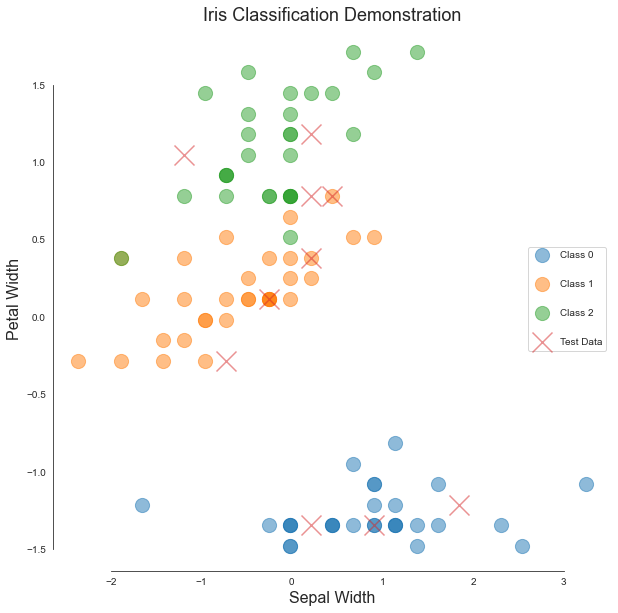

In [7]:
# Plot data set
# Number of training samples to show in plot
num_show = 10

fig, ax = plt.subplots(figsize=(10, 10))
x = d_train_sc[:, 1]
y = d_train_sc[:, 3]

for idx in np.unique(l_train):
    i = int(idx)
    ax.scatter(x[l_train == i], y[l_train == i], label=f'Class {i}',
              s=200, alpha=.5, cmap=cm.coolwarm)

xx = d_test_sc[:num_show, 1]
yy = d_test_sc[:num_show, 3]
ax.scatter(xx, yy, label='Test Data',
                   marker='x', s=400, alpha = .5, cmap=cm.coolwarm) 
        
# Decorate and clean plot
ax.set_xlabel('Sepal Width', fontsize=16)
ax.set_ylabel('Petal Width', fontsize=16)
ax.legend(loc = 7, labelspacing=2)
ax.set_title("Iris Classification Demonstration", fontsize=18)
sns.despine(offset=0, trim=True)

In [8]:
# Teaching a decision tree model

# First we construct our decision tree, we only specify the 
# random_state hyperparameter to ensure reproduceability.
dtc = DecisionTreeClassifier(random_state=23)

# Fit estimator to scaled training data
dtc = dtc.fit(d_train_sc, l_train)

# Compute and display accuracy score
score = 100.0 * dtc.score(d_test_sc, l_test)
print(f"Decision Tree prediction accuracy = {score:5.1f}%")

Decision Tree prediction accuracy =  96.7%


---

Notice that, even when using only 60% of the total data for training, our decision tree classifier still achieves remarkable accuracy on the testing data.
For completeness, we also display the classification report and the confusion matrix in the following two Code cells.

In [9]:
# Three types of Iris in data set
labels = ['Setosa', 'Versicolor', 'Virginica']

# Predict on test data and report scores
y_pred = dtc.predict(d_test_sc)
print(classification_report(l_test, y_pred, \
                            target_names = labels))

              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        21
  Versicolor       0.90      1.00      0.95        18
   Virginica       1.00      0.90      0.95        21

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



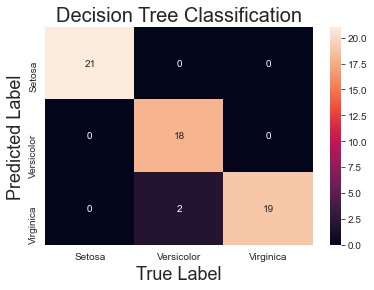

In [10]:
# plot a confusion matrix

# Make a 2D histogram from the test and result arrays
# pts is essentially the output of the scikit-learn

pts, xe, ye = np.histogram2d(l_test.reshape(l_test.shape[0]),
                            y_pred, 
                             bins=3)

# For simplicity we create a new DataFrame for the confusion matrix
pd_pts = pd.DataFrame(pts.astype(int), index=labels, columns=labels)

# Display heatmap and add decorations
hm = sns.heatmap(pd_pts, annot=True, fmt="d")
hm.axes.set_title('Decision Tree Classification', fontsize=20)
hm.axes.set_xlabel('True Label', fontsize=18)
hm.axes.set_ylabel('Predicted Label', fontsize=18);

## Feature Importance

The decision tree can often provide impressive performance rather easily.  We can, however, leverage the fact that the decision tree is constructed by repeatedly determining the most important feature on which to split the data to compute the relative importance of each feature in the training data set. In effect, this is computed by determining to what percentage each feature was used to split the training data, formally this is known as the _Gini importance_. As a result, higher values indicate a more important feature.

We demonstrate how to extract the feature importance for a decision tree classifier in the following Code cell, where we see that for this training data set, only two features: Petal Width and Petal Length account for most of the importance.

In [11]:
# Display feature importance as computed from the decision tree

# Feature names
feature_names = ['Sepal Length', 'Sepal Width',
               'Petal Length', 'Petal Width']

# Display name and importance
for name, val in zip(feature_names, dtc.feature_importances_):
    print(f'{name} importance = {100.0 * val :5.2f}%')

Sepal Length importance =  1.67%
Sepal Width importance =  2.22%
Petal Length importance =  5.59%
Petal Width importance = 90.51%


## Decision Surface

To better understand how a classification algorithm performs on a given data set and compare multiple classifiers, we can train a classifier and use this estimator to predict valued on a grid of values. In this case, we can see how the algorithm would classify data that spans a particular combination of feature values. This visualization, in two dimensions, is known as a decision surface since we are seeing how decisions would be made.

In the following code cells we will demonstrate ho to construct a decision surface. First, we need to reduce our data set down to two dimensions, using the `trim_data` function from `utils`, to make the decision surface visualtization. Next, we generate a two-dimensional mesh grid along these two dimensions.

We fit a decision tree to the trimmed two-dimensional data (we could also fit on the full data, but in this example we use only two dimensions), and apply to the mesh grid to construct the decision surface. Finally, we generate a scatter plot of the training data and color the underlying mesh appropriately by the predicted class for that cell.


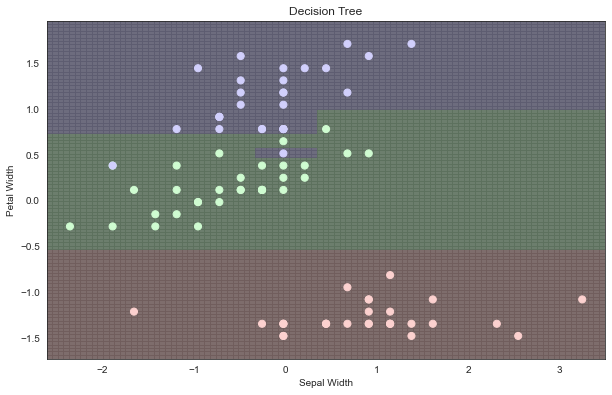

In [12]:
import utils

# Make a two-dimensional Iris data set
n_data = utils.trim_data(d_train_sc, l_train)

# Construct mesh grid data
mdata = utils.get_mdata(n_data)

fig, ax = plt.subplots(figsize=(10,8))

# Now train our model
dtc.fit(n_data[:,:2], n_data[:,2])
    
# Predict for mesh grid
z = dtc.predict(mdata)
    
# Plot training data and mesh grid
utils.splot_data(ax, n_data, mdata, z,
              'Sepal Width', 'Petal Width', 50)
    
ax.set_title(f'Decision Tree');

## Visualizing the Tree

A decision tree is one of the easiest algorithms to undestand since a decision tree essentially asks a list of questions to partition the data. The scikit learn library includes an `export_graphviz`  method that generates a visual tree representation of a constructed decision tree classifier. 

This representation is in the `dot` format recognized by the standard, open source `graphviz` library.

In [13]:
# First we construct our a shallow decision tree, this is
# simply a demonstration used to show feature improtance
# and how to view a tree, hence we need a shallow tree
dtc = DecisionTreeClassifier(max_depth=3, random_state=23)

dtc = dtc.fit(d_train_sc, l_train)

### Using `graphviz`

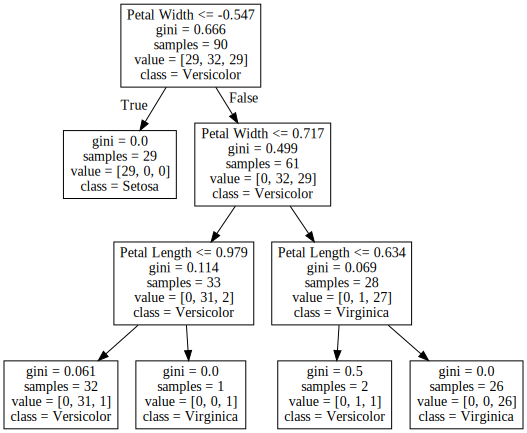

In [25]:
import graphviz 
tree_data = export_graphviz(dtc, class_names=labels, 
                            feature_names=feature_names,
                            out_file=None) 
my_tree = graphviz.Source(tree_data) 
my_tree 

### Using `sklearn`

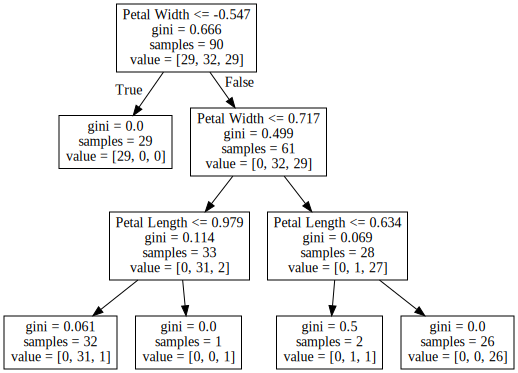

In [24]:
from sklearn.tree import export_graphviz

# Write the dot representation of the tree to a file
with open('tree.dot', 'w') as fdot:
    export_graphviz(dtc, fdot, feature_names=feature_names)
# We run the dot tool at the command line to create a viewable image.
!dot -Tsvg tree.dot -o tree.svg
# Now display the image inline
from IPython.display import SVG
SVG(filename='tree.svg')